# Classification avec BERT

Le but est d'utiliser le modèle BERT afin de prédire si un tweet parle d'un désastre. La difficulté du problème étant que les mots peuvent avoir plusieurs sens. On procède donc avec un fine tuning d'un BERT pré-entrainé, procède à l'évaluation, et enfin enlevons des couches au modèle afin de considérer le BERT comme un classificateur adapté pour du clustering.

## Imports

In [2]:
import pandas as pd
import numpy as np
import pickle
import logging
from multiprocessing import Pool, cpu_count
from tqdm import tqdm_notebook 
from tqdm import trange
import collections
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,\
                              TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification, AdamW,\
                get_linear_schedule_with_warmup

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from CONSTS import *
from tools import *

In [3]:
DATA_DIR = "./data/"
OUTPUT_DIR = './outputs/'
LOG_DIR = "./logs/"
SAVES_DIR = "./saves/"
CACHE_DIR = "./cache/"
WEIGHTS_NAME = "pytorch_model.bin"
CONFIG_NAME = "config.json"

MAX_SEQ_LENGTH = 80
TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1
OUTPUT_MODE = 'classification'


## Preprocessing (LEARNING MODE)

On convertit les tweets au format tsv afin de facilier l'intégration avec BERT

In [4]:
def cleaner(x):
    return x.replace(r'\n', ' ', regex=True)

def to_tsv(X, filename = "train"):
    prepro_X = pd.DataFrame({
        'id': range(X.shape[0]),
        'label': (X.choose_one == "Relevant")*1,
        "alpha": ['a']*X.shape[0],
        'text': cleaner(X.text),
        "keyword": X.keyword
    })
    prepro_X.to_csv(DATA_DIR + filename +'.tsv', sep='\t', index=False, header=False)
    return prepro_X


In [5]:
X = pd.read_excel("./Classeur1.xlsx")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, X_test, y_train, y_test = train_test_split(
X, X.choose_one, test_size=0.2, random_state=42)
to_tsv(X_train, "train")
to_tsv(X_test, "dev")
to_tsv(X, "full")
pass

In [6]:
X_train.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
8491,778253309,False,finalized,5,8/27/15 16:07,Not Relevant,1.0000,NaN,screamed,NaN,i dont even remember slsp happening i just rem...,6.291070e+17,2.327739e+08
7178,778251995,False,finalized,5,8/27/15 20:16,Not Relevant,1.0000,NaN,mudslide,Edinburgh,@hazelannmac ooh now I feel guilty about wishi...,6.290180e+17,2.750220e+07
2423,778247239,False,finalized,5,8/30/15 0:15,Not Relevant,1.0000,NaN,collide,planeta H2o,Soultech - Collide (Club Mix) http://t.co/8xIx...,6.290920e+17,6.052387e+08
10612,778255430,False,finalized,5,8/27/15 17:03,Relevant,0.7978,NaN,wounded,NaN,Police Officer Wounded Suspect Dead After Exch...,6.291190e+17,2.305930e+09
10791,778255609,False,finalized,5,8/27/15 22:11,Not Relevant,1.0000,NaN,wrecked,Sunny Southern California,Cramer: Iger's 3 words that wrecked Disney's s...,6.290800e+17,2.464266e+07


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
processor = BinaryClassificationProcessor()
train_examples = processor.get_train_examples(DATA_DIR)
train_examples_len = len(train_examples)
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
num_train_optimization_steps = int(
    train_examples_len / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS) * NUM_TRAIN_EPOCHS
label_map = {label: i for i, label in enumerate(label_list)}
train_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in train_examples]

In [ ]:
process_count = max(cpu_count() - 1, 1)

In [ ]:

if __name__ ==  '__main__':
    print(f'Preparing to convert {train_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        train_features = list(tqdm_notebook(p.imap(convert_example_to_feature, train_examples_for_processing), total=train_examples_len))

In [8]:
# with open(DATA_DIR + "train_features.pkl", "wb") as f:
#     pickle.dump(train_features, f)

In [9]:
with open(DATA_DIR + "train_features.pkl", "rb") as f:
    train_features = pickle.load(f)

In [10]:
BERT_MODEL = 'bert-base-cased'
# model = BertForSequenceClassification.from_pretrained(CACHE_DIR + 'cased_base_bert_pytorch.tar.gz', cache_dir=CACHE_DIR, num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, cache_dir=CACHE_DIR, num_labels=num_labels)

In [11]:
model.to(device)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

#optimizer = AdamW(optimizer_grouped_parameters,
#                      lr=LEARNING_RATE,
#                      warmup=WARMUP_PROPORTION,
#                      t_total=num_train_optimization_steps)
optimizer = AdamW(optimizer_grouped_parameters,lr=LEARNING_RATE, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_PROPORTION, num_training_steps=num_train_optimization_steps)  # PyTorch scheduler

In [13]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0

In [14]:
logger.info("***** Running training *****")
logger.info("  Num examples = %d", train_examples_len)
logger.info("  Batch size = %d", TRAIN_BATCH_SIZE)
logger.info("  Num steps = %d", num_train_optimization_steps)
all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)


all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)

In [15]:
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=TRAIN_BATCH_SIZE)

In [18]:
max_grad_norm = 1

In [19]:
model.train()
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, segment_ids, input_mask, labels=None)
        loss_fct = CrossEntropyLoss()
        logits = outputs[0]
        loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        
        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        print("\r%f" % loss, end='')
        
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

0.422846


Epoch: 100%|██████████| 1/1 [01:51<00:00, 111.50s/it]


In [20]:
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(OUTPUT_DIR, WEIGHTS_NAME)
output_config_file = os.path.join(OUTPUT_DIR, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(OUTPUT_DIR)

('./outputs/vocab.txt',)

## Evaluation (standalone)
Le but est de prendre le modèle de BERT qui a été fine tuné, et de pouvoir évaluer ses classifications

In [12]:
def get_eval_report(task_name, labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "task": task_name,
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }

def compute_metrics(task_name, labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(task_name, labels, preds)

In [13]:
tokenizer = BertTokenizer.from_pretrained(OUTPUT_DIR + 'vocab.txt', do_lower_case=False)

In [14]:
processor = BinaryClassificationProcessor()
eval_examples = processor.get_dev_examples(DATA_DIR)
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
eval_examples_len = len(eval_examples)

In [15]:
label_map = {label: i for i, label in enumerate(label_list)}
eval_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in eval_examples]

In [16]:
process_count = max(cpu_count() - 1, 1)


In [17]:
if __name__ ==  '__main__':
    print(f'Preparing to convert {eval_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        eval_features = list(tqdm_notebook(p.imap(convert_example_to_feature, eval_examples_for_processing), total=eval_examples_len))

Preparing to convert 2176 examples..
Spawning 15 processes..


In [18]:
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)

eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=EVAL_BATCH_SIZE)

In [19]:
# Load pre-trained model (weights)
model = BertForSequenceClassification.from_pretrained(OUTPUT_DIR, cache_dir=CACHE_DIR, num_labels=len(label_list),\
                                                     output_attentions=True)

In [20]:
model.to(device)
pass

In [81]:
model.eval()
eval_loss = 0
nb_eval_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        logits, attention = model(input_ids, segment_ids, input_mask, labels=None)

    loss_fct = CrossEntropyLoss()
    tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
    eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

eval_loss = eval_loss / nb_eval_steps
preds = preds[0]
preds = np.argmax(preds, axis=1)
result = compute_metrics("test", all_label_ids.numpy(), preds)

result['eval_loss'] = eval_loss

output_eval_file = os.path.join("./logs/", "eval_results.txt")

with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in (result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

La matrice de confusion est dans le fichier "./logs/eval_results.txt"

In [ ]:
# %load ./logs/eval_results.txt
task = test
mcc = 0.6518165924885155
tp = 728
tn = 1076
fp = 143
fn = 229
eval_loss = 0.39927673416540904


## Mode clustering
Le but est enfin de prendre les couches inférieures de BERT en considérant que le BERT fine tuné peut servir de classificateur sur nos données

In [21]:
    all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
    all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)

    eval_data = TensorDataset(all_input_ids, all_input_mask, all_example_index)

In [22]:
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=EVAL_BATCH_SIZE)

In [23]:
tokenizer = BertTokenizer.from_pretrained(OUTPUT_DIR + 'vocab.txt', do_lower_case=False)
processor = BinaryClassificationProcessor()
train_examples = processor.get_full_examples(DATA_DIR)
train_examples_len = len(train_examples)
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
num_train_optimization_steps = int(
    train_examples_len / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS) * NUM_TRAIN_EPOCHS
label_map = {label: i for i, label in enumerate(label_list)}
train_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in train_examples]

In [ ]:
process_count = max(cpu_count() - 1, 1)
if __name__ ==  '__main__':
    print(f'Preparing to convert {train_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        eval_features = list(tqdm_notebook(p.imap(convert_example_to_feature, train_examples_for_processing), total=train_examples_len))

In [ ]:
# with open(DATA_DIR + "full.pkl", "wb") as f:
#     pickle.dump(eval_features, f)


In [41]:
with open(DATA_DIR + "full.pkl", "rb") as f:
    eval_features = pickle.load(f)

In [42]:
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
all_texts =[f.example.text_a for f in eval_features]
all_keywords = [f.example.keyword for f in eval_features]

eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)

In [28]:
model = BertForSequenceClassification.from_pretrained(OUTPUT_DIR, cache_dir=CACHE_DIR, num_labels=len(label_list),\
                                                     output_attentions=True)
model.classifier = nn.Sequential(*list(model.classifier.children())[:-3])

In [29]:
model.to(device)
pass

In [77]:
model.eval()
eval_loss = 0
nb_eval_steps = 0
preds = []
for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        logits, attention = model(input_ids, segment_ids, input_mask, labels=None)

    nb_eval_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

In [78]:
# with open(DATA_DIR + "preds.pkl", "wb") as f:
#     pickle.dump(preds[0], f)


In [30]:
with open(DATA_DIR + "preds.pkl", "rb") as f:
    preds = [pickle.load(f)]

In [46]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)


In [47]:
tsne_results = tsne.fit_transform(preds[0])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10876 samples in 0.494s...
[t-SNE] Computed neighbors for 10876 samples in 48.183s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10876
[t-SNE] Computed conditional probabilities for sample 2000 / 10876
[t-SNE] Computed conditional probabilities for sample 3000 / 10876
[t-SNE] Computed conditional probabilities for sample 4000 / 10876
[t-SNE] Computed conditional probabilities for sample 5000 / 10876
[t-SNE] Computed conditional probabilities for sample 6000 / 10876
[t-SNE] Computed conditional probabilities for sample 7000 / 10876
[t-SNE] Computed conditional probabilities for sample 8000 / 10876
[t-SNE] Computed conditional probabilities for sample 9000 / 10876
[t-SNE] Computed conditional probabilities for sample 10000 / 10876
[t-SNE] Computed conditional probabilities for sample 10876 / 10876
[t-SNE] Mean sigma: 0.662595
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.672668
[t-SNE] K

In [92]:
# with open(DATA_DIR + "tsne.pkl", "wb") as f:
#     pickle.dump(tsne_results, f)


In [56]:
with open(DATA_DIR + "tsne.pkl", "rb") as f:
    tsne_results = pickle.load(f)

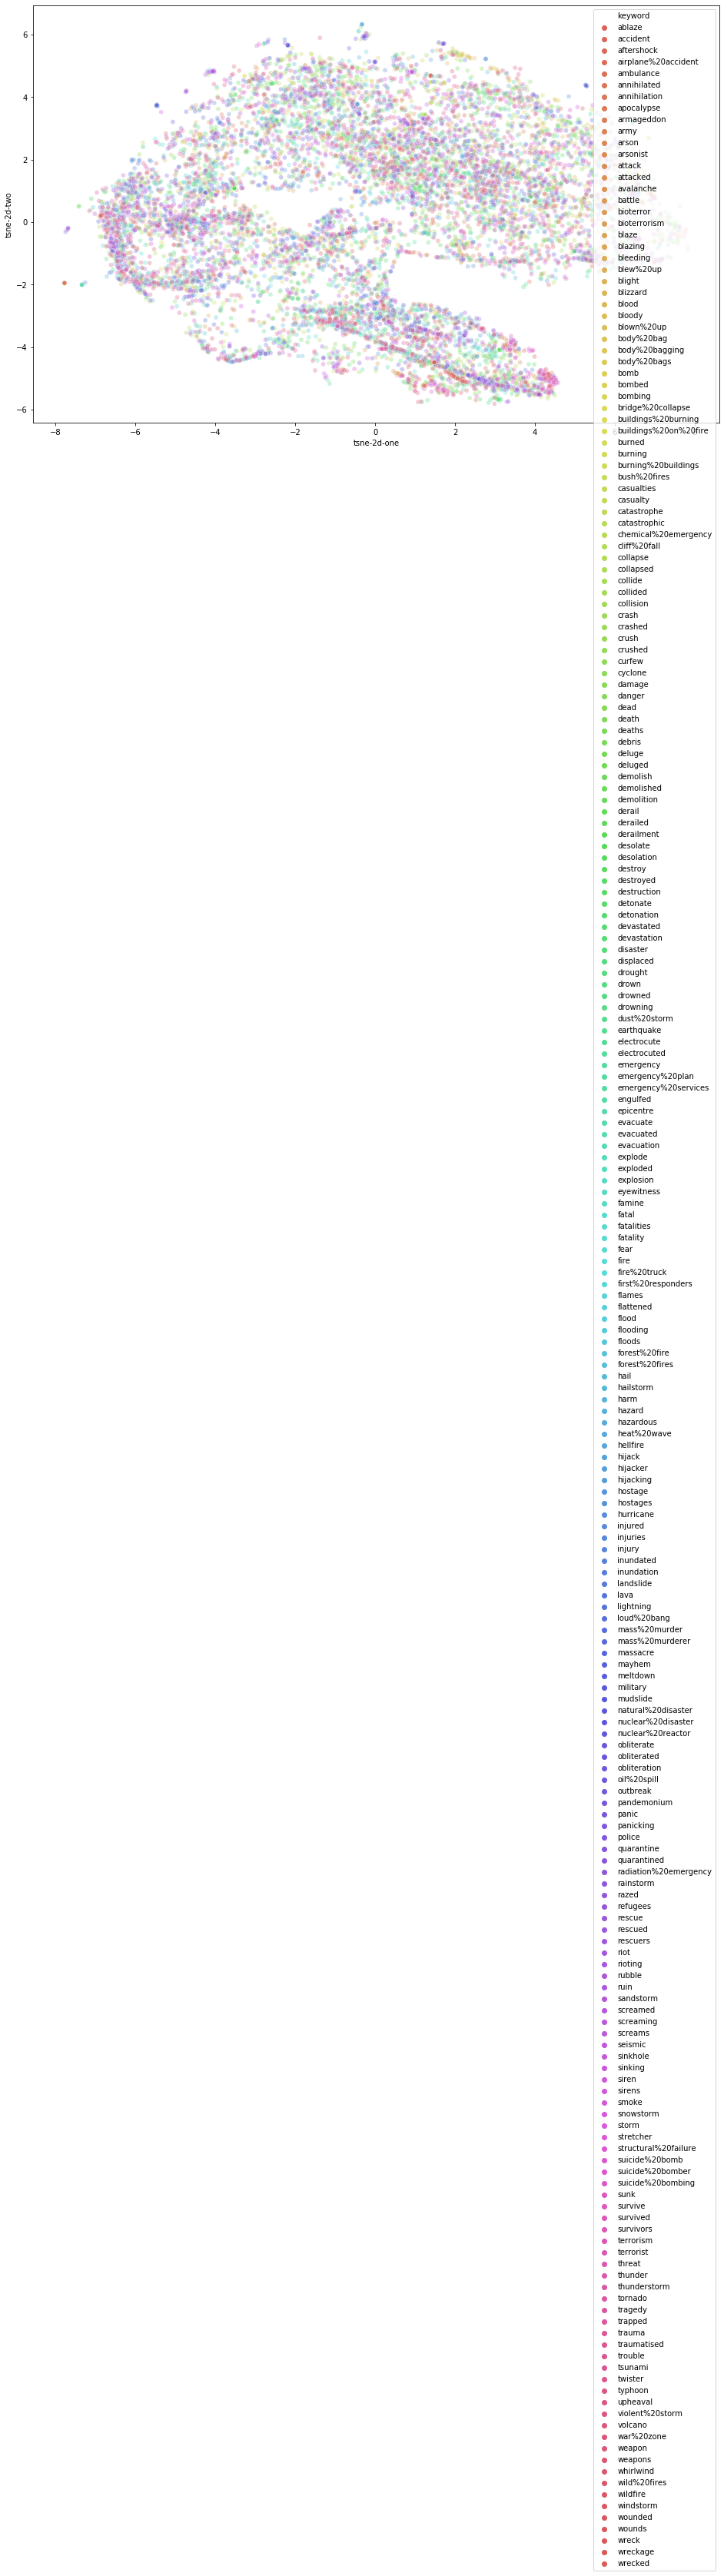

In [57]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['label'] = [f.label_id for f in eval_features]
df_subset["keyword"] = all_keywords
df_subset["mask"] = True

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="keyword",
    palette=sns.color_palette("hls", len(set(all_keywords))),
    data=df_subset,
    alpha=0.3
)

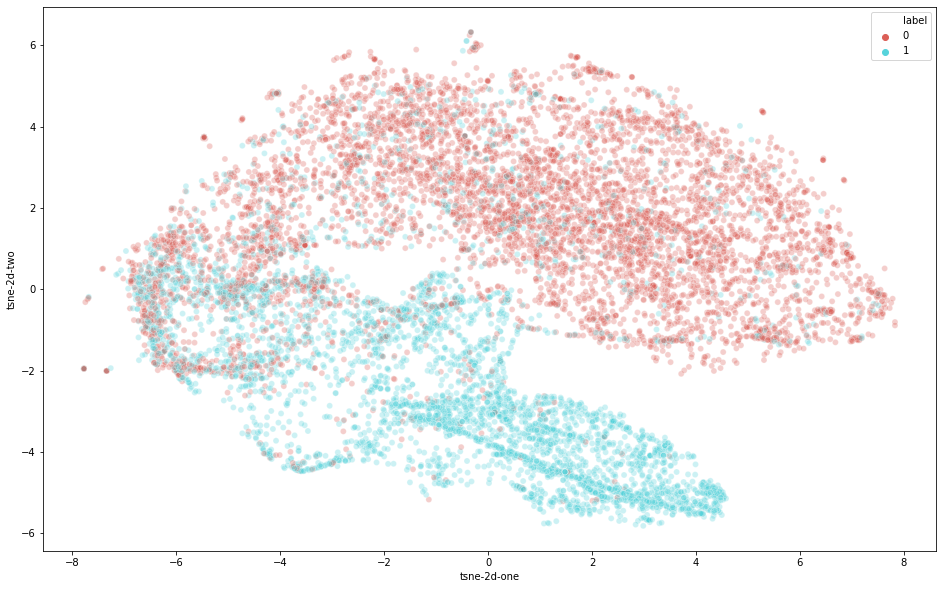

In [58]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['label'] = [f.label_id for f in eval_features]
df_subset["keyword"] = all_keywords
df_subset["mask"] = True

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 2),# len(set(all_keywords))),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [59]:
words = df_subset.keyword.unique()

In [60]:
i = 0

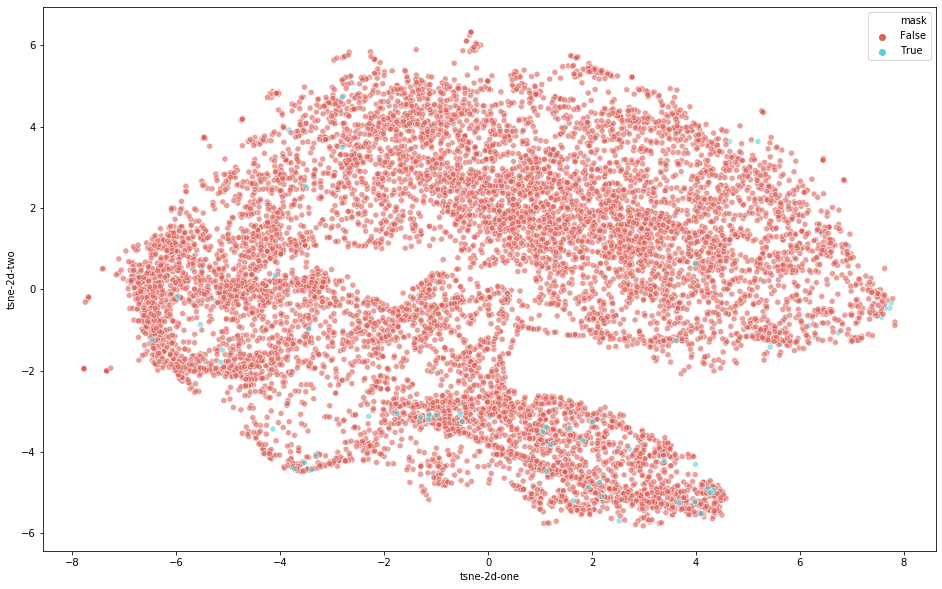

In [61]:
df_subset["mask"] = (df_subset["keyword"] == words[i])
i+=1
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="mask",
    palette=sns.color_palette("hls", 2),# len(set(all_keywords))),
    data=df_subset,
    legend="full",
    alpha=0.6
)